<a href="https://colab.research.google.com/github/Eukio/CS4372HW3/blob/main/CS4372_HW3_ETT220002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN Training Monkey Species- HW 3
Eucharist Tan - ETT220002
CS4372
11/5/25

In [ ]:
# 1. Run import statements
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import cv2
import skimage.transform
import scipy.misc
import glob


In [ ]:
# 2. Download Data
import kagglehub

path = kagglehub.dataset_download("slothkong/10-monkey-species")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '10-monkey-species' dataset.
Path to dataset files: /kaggle/input/10-monkey-species


In [ ]:
# 3. View Data
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv(f'{path}/monkey_labels.txt', sep=',', names=cols)
labels

Label                Latin Name                      Common Name  \
0   Label     Latin Name              Common Name                      
1   n0         alouatta_palliata\t    mantled_howler                   
2   n1        erythrocebus_patas\t    patas_monkey                     
3   n2        cacajao_calvus\t        bald_uakari                      
4   n3        macaca_fuscata\t        japanese_macaque                 
5   n4       cebuella_pygmea\t        pygmy_marmoset                   
6   n5       cebus_capucinus\t        white_headed_capuchin            
7   n6       mico_argentatus\t        silvery_marmoset                 
8   n7      saimiri_sciureus\t        common_squirrel_monkey           
9   n8       aotus_nigriceps\t        black_headed_night_monkey        
10  n9       trachypithecus_johnii    nilgiri_langur                   

      Train Images   Validation Images  
0    Train Images    Validation Images  
1    131                            26  
2    139                            28  
3    137                            27  
4    152                            30  
5    131                            26  
6    141                            28  
7    132                            26  
8    142                            28  
9    133                            27  
10   132                            26

In [ ]:
# 4. Create datasets
train_dir = f'{path}/training/training'
validation_dir = f'{path}/validation/validation'
BATCH_SIZE = 20
IMG_SIZE = (224,224)
NUM_CLASSES = 10
initial_epochs = 10


train_dataset = image_dataset_from_directory(train_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1097 files belonging to 10 classes.
Found 272 files belonging to 10 classes.


In [ ]:
# 5. One hot encode data for classification
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=NUM_CLASSES)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
).map(one_hot_encode)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
).map(one_hot_encode)
for images, labels in train_ds.take(1):
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    print("First label (one-hot):", labels[0].numpy())


Found 1097 files belonging to 10 classes.
Found 272 files belonging to 10 classes.
Image shape: (20, 224, 224, 3)
Label shape: (20, 10)
First label (one-hot): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
# 6. Create splits for testing/validation
val_batches = tf.data.experimental.cardinality(validation_dataset).numpy()
test_size = int(val_batches * 0.2)

test_dataset = validation_dataset.take(test_size)
validation_dataset = validation_dataset.skip(test_size)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 12
Number of test batches: 2


In [ ]:
# 7. Autotune
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

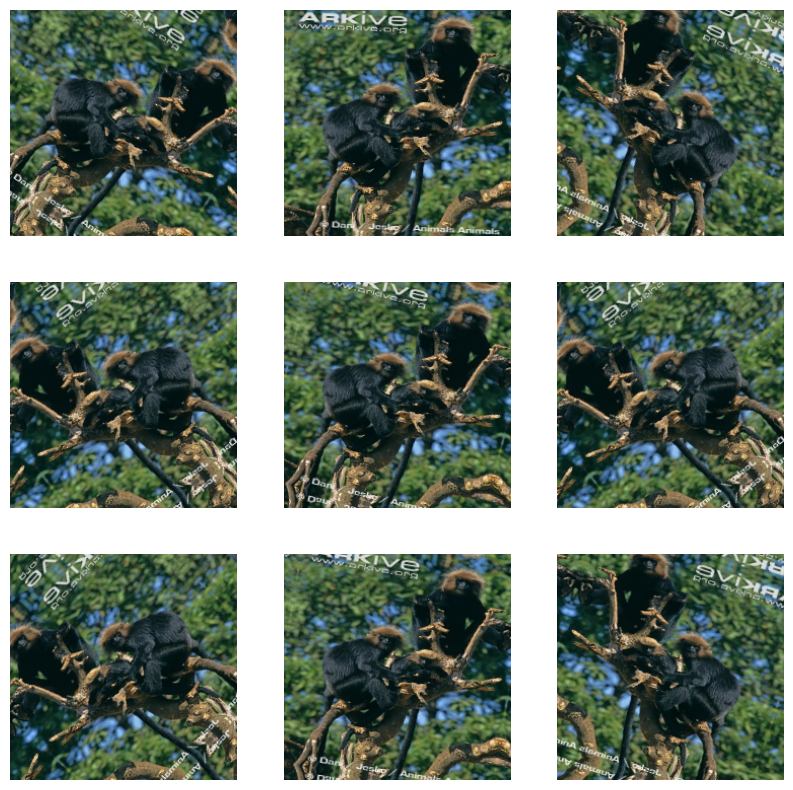

In [ ]:
# 8. Apply Data Augumentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#9. View model summary
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
base_model.summary()

(20, 7, 7, 1280)


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#10. Create layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

#Add dense layer to make prediction as logit
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
# Change the output layer for 10 classes with softmax activation
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

(20, 1280)
(20, 1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

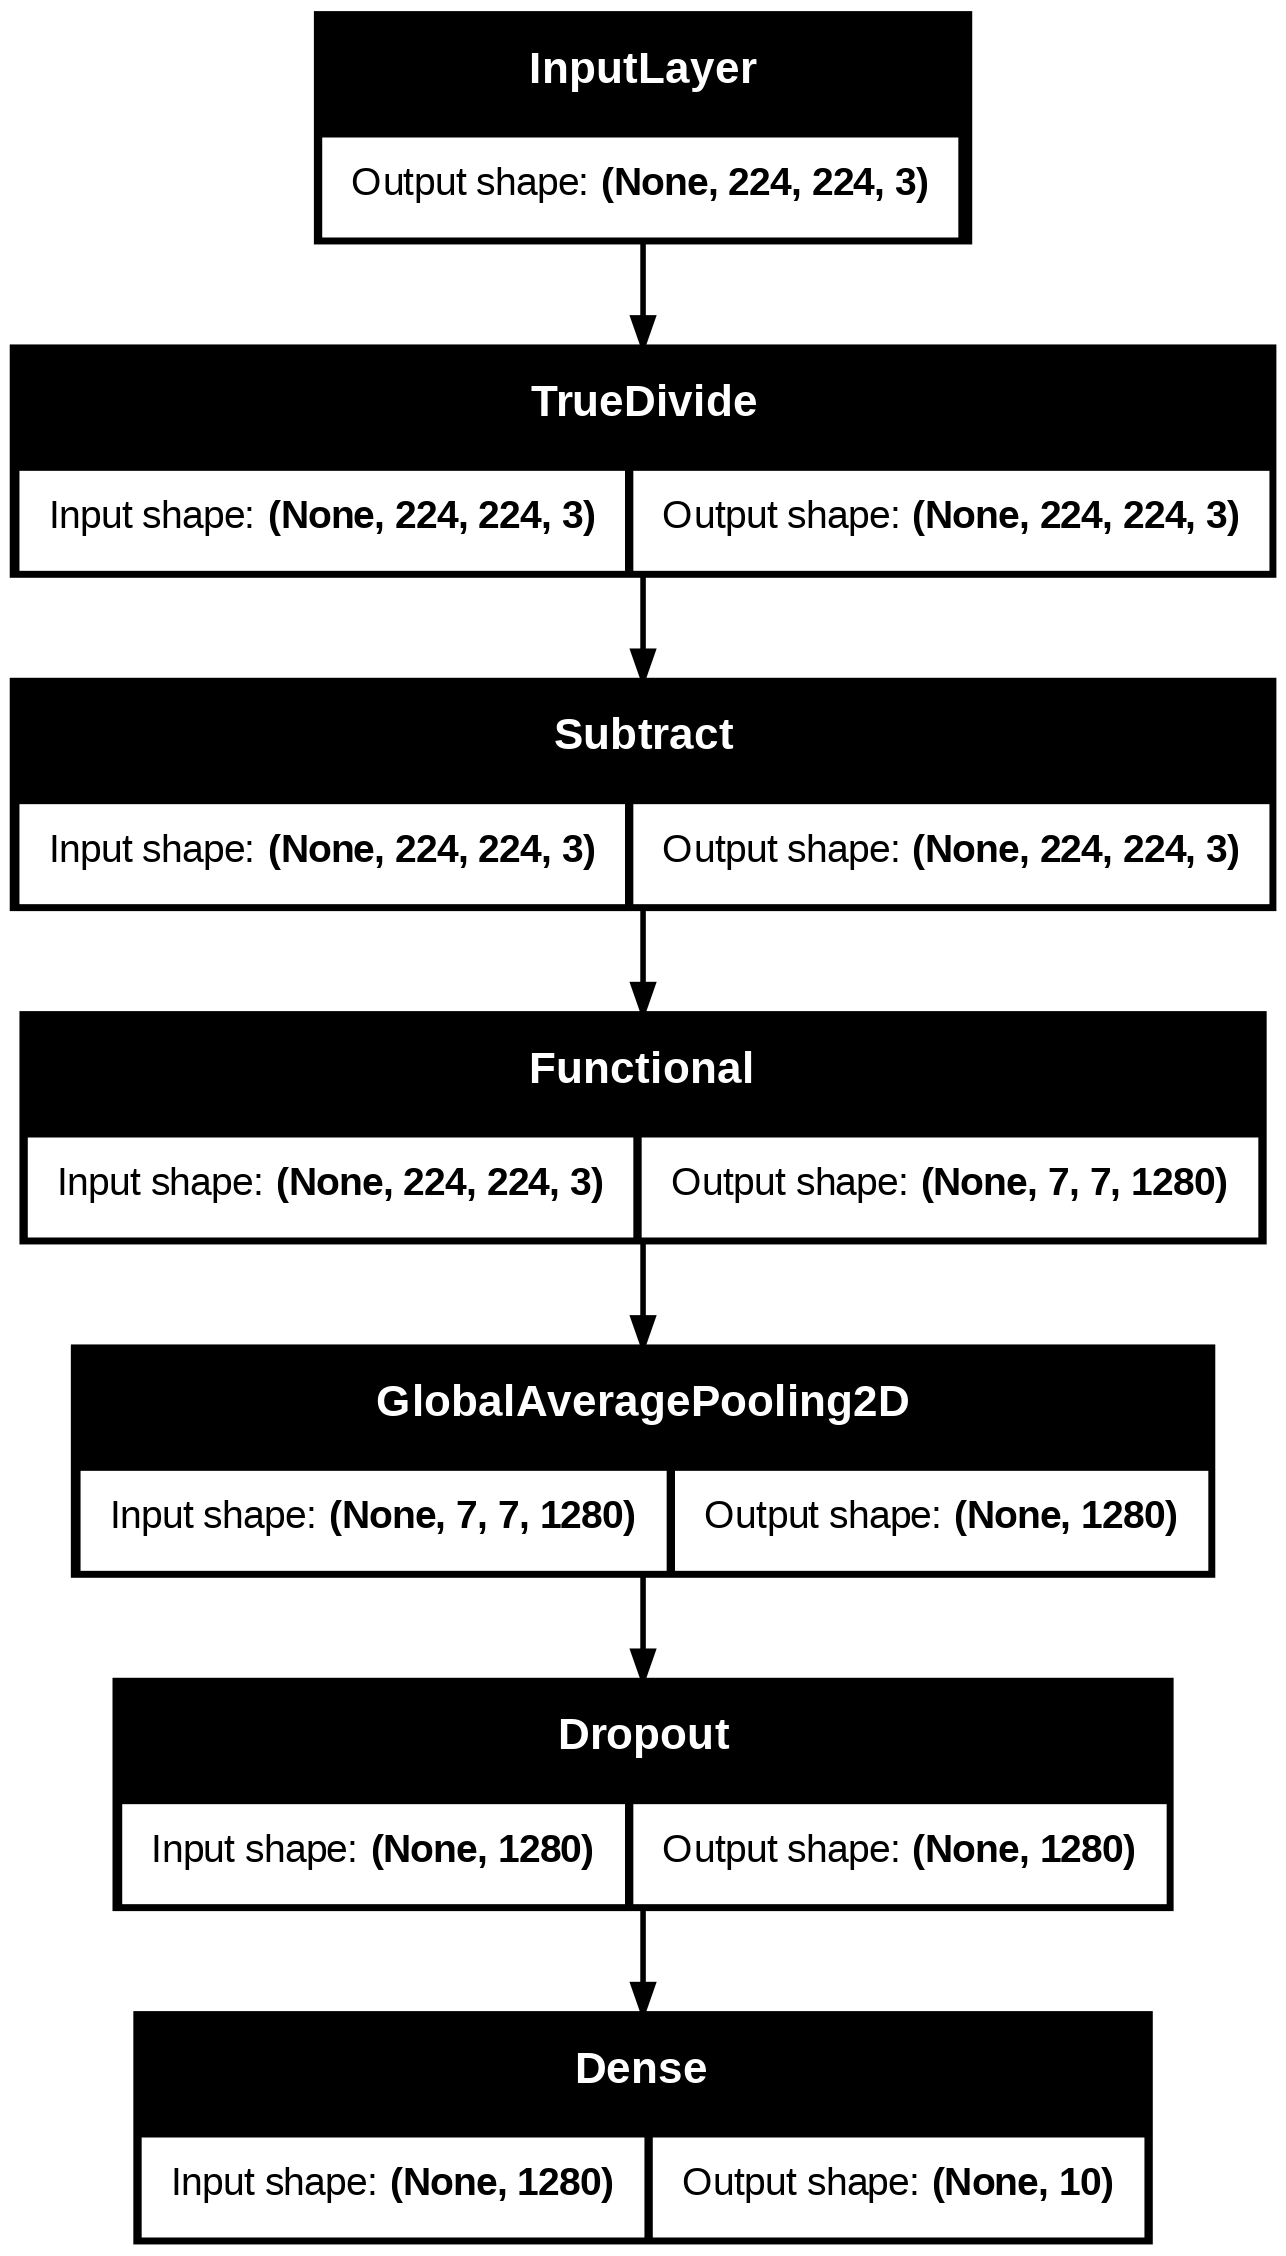

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#11. Fit model
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
               metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 683ms/step - accuracy: 0.1154 - loss: 2.6286 - val_accuracy: 0.3125 - val_loss: 1.9757
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - accuracy: 0.3285 - loss: 1.9136 - val_accuracy: 0.6360 - val_loss: 1.5223
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step - accuracy: 0.5764 - loss: 1.4774 - val_accuracy: 0.8125 - val_loss: 1.1597
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.7735 - loss: 1.0962 - val_accuracy: 0.8897 - val_loss: 0.8815
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.8959 - loss: 0.8368 - val_accuracy: 0.9228 - val_loss: 0.6752
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.9467 - loss: 0.6244 - val_accuracy: 0.9265 - val_loss: 0.5279
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - accuracy: 0.9512 - loss: 0.4796 - val_accuracy: 0.9412 - val_loss: 0.4228
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - accuracy: 0.9611 - loss: 0.3818 - val_accu

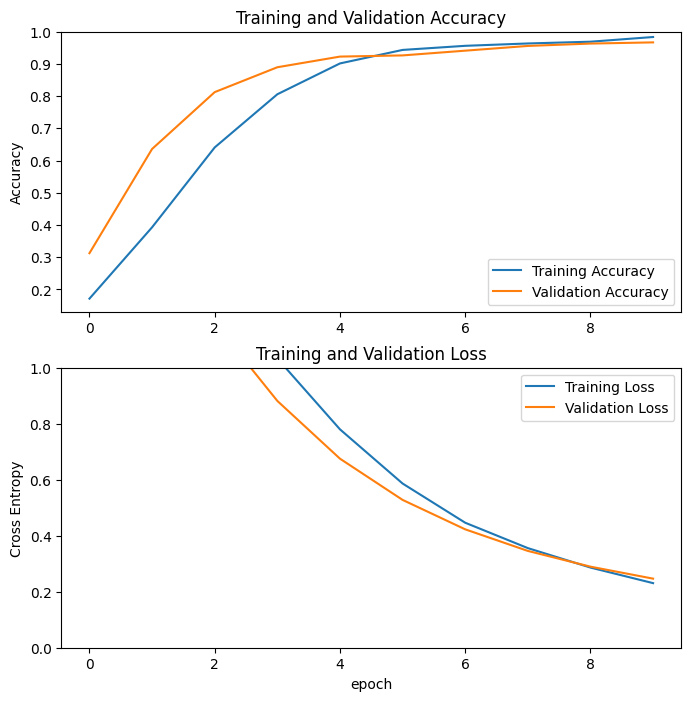

Final test accuracy: 0.966911792755127
Final training accuracy: 0.983591616153717


In [ ]:
#12. Plot model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print("Final test accuracy:", val_acc[-1])
print("Final training accuracy:", acc[-1])


In [ ]:
# 13. Freeze layers
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# 14. Compile layers
base_model.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
               metrics=['accuracy'])

In [ ]:
# 15. Fine tune
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)


Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 774ms/step - accuracy: 0.7149 - loss: 0.8634 - val_accuracy: 0.9596 - val_loss: 0.1823
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.8753 - loss: 0.4852 - val_accuracy: 0.9559 - val_loss: 0.1527
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.9277 - loss: 0.3424 - val_accuracy: 0.9596 - val_loss: 0.1312
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.9657 - loss: 0.2166 - val_accuracy: 0.9596 - val_loss: 0.1139
Epoch 15/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.9795 - loss: 0.1583 - val_accuracy: 0.9669 - val_loss: 0.1001
Epoch 16/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.9852 - loss: 0.1269 - val_accuracy: 0.9743 - val_loss: 0.0940
Epoch 17/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.9925 - loss: 0.0968 - val_accuracy: 0.9779 - val_loss: 0.0841
Epoch 18/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - accuracy: 0.9955 - loss: 0.0685 - 

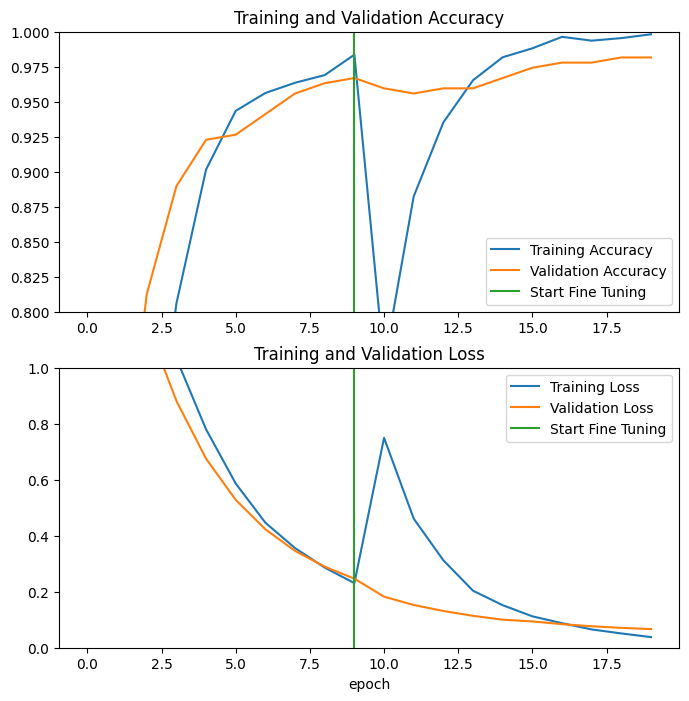

In [ ]:
# 16. View plots
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:

print("Final test accuracy:", val_acc[-1])
print("Final training accuracy:", acc[-1])

Final test accuracy: 0.9816176295280457
Final training accuracy: 0.9981768727302551


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


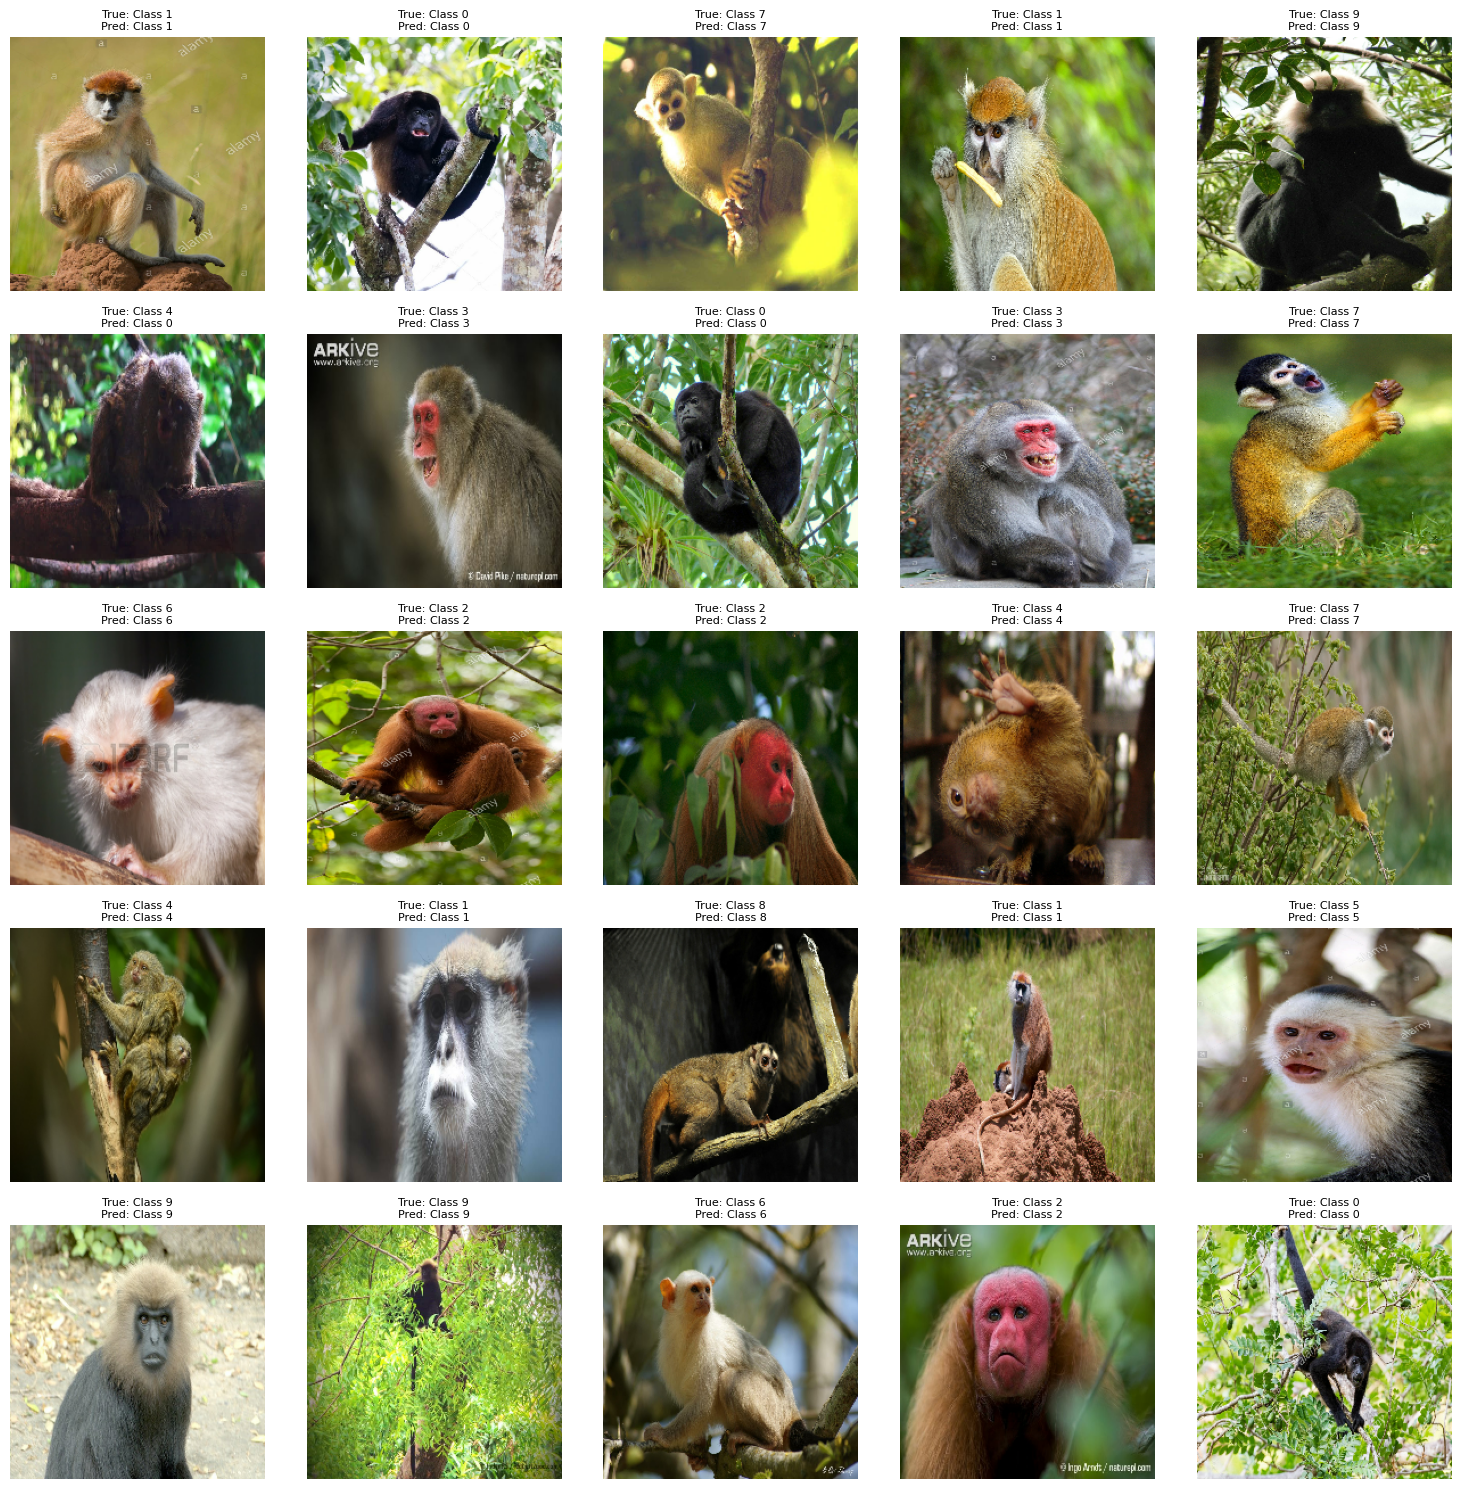

In [ ]:
# 17. Unbatch and collect 25 samples
images, true_labels = [], []
for img, label in test_dataset.unbatch().take(25):
    images.append(img)
    true_labels.append(label)

images_np = tf.stack(images)
pred_probs = model.predict(images_np)
pred_labels = tf.argmax(pred_probs, axis=1).numpy()

true_labels_decoded = [tf.argmax(lbl).numpy() if len(lbl.shape) > 0 else lbl.numpy() for lbl in true_labels]

# Class names
class_names = test_dataset.class_names if hasattr(test_dataset, 'class_names') else [f"Class {i}" for i in range(10)]

# Plot
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true = class_names[true_labels_decoded[i]]
    pred = class_names[pred_labels[i]]
    plt.title(f"True: {true}\nPred: {pred}", fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()